In [2]:
import gdown, glob, os, shutil, zipfile, time
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

In [3]:
csv_data = pd.read_csv('/content/drive/MyDrive/Research_Assistant/Skin_lesion/Data/ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv')

In [5]:
csv_data['interaction_modality'].unique()

array(['Malignancy Probability (AI)', 'Multiclass Probabilities (Crowd)',
       'CBIR (AI)', 'Multiclass Probabilities (AI)'], dtype=object)

In [7]:
metadata = pd.read_csv('/content/drive/MyDrive/Research_Assistant/Skin_lesion/Data/HAM10000_metadata')

In [8]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [12]:
source1 = '/content/drive/MyDrive/Research_Assistant/Skin_lesion/Data/img_part_1/'
source2 = '/content/drive/MyDrive/Research_Assistant/Skin_lesion/Data/img_part_2/'
dest = '/content/drive/MyDrive/Research_Assistant/Skin_lesion/Data/Images/'

for filename in glob.glob(source1+'*'):
  filename_new = dest + filename.split('/')[-1]
  shutil.move(filename, filename_new)

for filename in glob.glob(source2+'*'):
  filename_new = dest + filename.split('/')[-1]
  shutil.move(filename, filename_new)

In [26]:
imageid_path_dict = {filename.split('/')[-1].split('.')[0]: filename
                     for filename in glob.glob(dest+'*')}

lesion_type_dict = {
    'nv': 'Melanocytic_nevi',
    'mel': 'melanoma',
    'bkl': 'Benign_keratosis-like_lesions',
    'bcc': 'Basal_cell_carcinoma',
    'akiec': 'Actinic_keratoses',
    'vasc': 'Vascular_lesions',
    'df': 'Dermatofibroma'
}

lesion_danger = {
    'nv': 0, # 0 for benign
    'mel': 1, # 1 for malignant
    'bkl': 0, # 0 for benign
    'bcc': 1, # 1 for malignant
    'akiec': 1, # 1 for malignant
    'vasc': 0,
    'df': 0
}

In [28]:
metadata["path"] = metadata["image_id"].map(imageid_path_dict.get) # map image_id to the path of that image

In [29]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...


In [30]:
metadata["cell_type"] = metadata["dx"].map(lesion_type_dict.get)

In [31]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Benign_keratosis-like_lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Benign_keratosis-like_lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Benign_keratosis-like_lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Benign_keratosis-like_lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Benign_keratosis-like_lesions
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Actinic_keratoses
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Actinic_keratoses
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Actinic_keratoses
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/drive/MyDrive/Research_Assistant/Skin...,Actinic_keratoses


In [32]:
metadata["cell_type_idx"] = pd.Categorical(metadata["cell_type"]).codes

In [35]:
metadata['cell_type'].value_counts()

Melanocytic_nevi                 6705
melanoma                         1113
Benign_keratosis-like_lesions    1099
Basal_cell_carcinoma              514
Actinic_keratoses                 327
Vascular_lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64

In [39]:
sample = metadata.sample(5)

In [51]:
images = sample['path']
types =  list(sample['cell_type'])

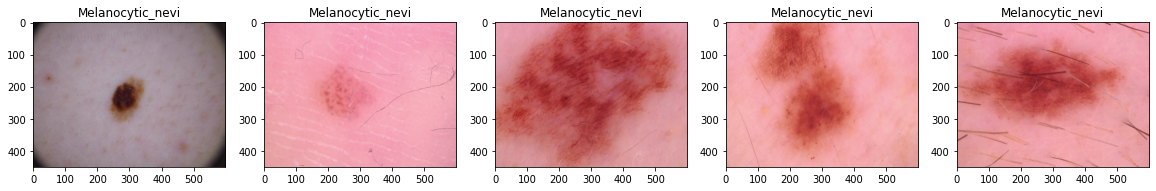

In [57]:
import skimage.io as ski

plt.figure(figsize=(20, 20))
for i, path in enumerate(images):
  image = ski.imread(path)
  plt.subplot(1, len(images), i+1)
  plt.imshow(image)
  plt.title(types[i])